In [ ]:
## IF You run this script on COLAB, You should run this cell

# import os
# import sys
# if not os.path.exists("./ocr-text-recognition"):
#     !git clone https://github.com/pai-sj/ocr-text-recognition.git    
#     !pip install -r ocr-text-recognition/requirements.txt
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq
# sys.path.append("./ocr-text-recognition")
# os.chdir("/content/ocr-text-recognition/scripts/")

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import re
import sys
sys.path.append("../")
from functools import partial

from utils.dataset import OCRDataset
from models.generator import JAMOSeq2SeqGenerator
from models.jamo import compose_unicode
from models.losses import jamo_categorical_crossentropy

from tensorflow.keras.callbacks import ReduceLROnPlateau
from models.optimizer import AdamW


import tensorflow as tf 
assert int(tf.__version__[:1]) < 2.0, "해당 코드는 1.x에서만 동작합니다."
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.font_manager as fm
FONT_LIST = [f.name for f in fm.fontManager.ttflist]
FONT_LIST = list(set([f for f in FONT_LIST if "Nanum" in f and not 'Square' in f]))

## 한글 Matplotlib 출력 세팅

In [2]:
# 1. 나눔 폰트를 다운받기
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
# 2. 나눔 폰트의 위치 가져오기 
system_font = fm.findSystemFonts() # 현재 시스템에 설치된 폰트
nanum_fonts = [font for font in system_font if "NanumBarunGothic.ttf" in font]
font_path = nanum_fonts[0] # 설정할 폰트의 경로

# 3. 나눔 폰트로 설정하기
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc("font",family=font_name)

# 4. 폰트 재설정하기
fm._rebuild()

# 5. (optional) minus 기호 깨짐 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.font_manager as fm
FONT_LIST = [f.name for f in fm.fontManager.ttflist]
FONT_LIST = list(set([f for f in FONT_LIST if "Nanum" in f and not 'Square' in f]))

/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found


# \[ OCR 데이터셋 \]

## 1. 데이터 가져오기 

In [3]:
# 단어 최소/최대 길이
min_words = 4
max_words = 8

df = pd.read_csv("../datasets/wordslist.txt",names=['word'])
df = df.drop_duplicates()
df = df[df.word.str.match(r'^[가-힣]+$')]
df = df[
    df.word.map(
        lambda x: (len(x) >= min_words) 
        and (len(x) <= max_words))]
words = df.word.values
np.random.shuffle(words)
words = np.append(words,"정보화진흥원")

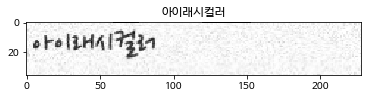

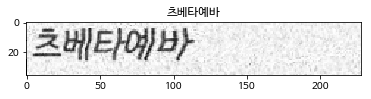

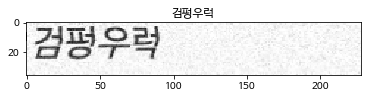

In [4]:
# OCRDataset setting
OCRDataset = partial(OCRDataset,
                     font_size=24,
                     bg_noise=0.2,
                     affine_noise=(0.0,0.01),
                     normalize=False,
                     random_shift=False,                     
                     color_noise=(0.1,0.3),
                     gray_scale=True,
                     font_list=FONT_LIST)

dataset = OCRDataset(words)
images, labels = dataset[0:3]

for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()

## 2. 데이터 Generator 가져오기

In [5]:
# 단어 군을 기준으로 나누기 
# validation words는 5%만 둚
valid_words = words[:len(words)*5//100]
train_words = words[len(words)*5//100:]
train_words = train_words

valid_set = OCRDataset(valid_words)
train_set = OCRDataset(train_words)

train_gen = JAMOSeq2SeqGenerator(train_set, batch_size=64)
valid_gen = JAMOSeq2SeqGenerator(valid_set, batch_size=64)

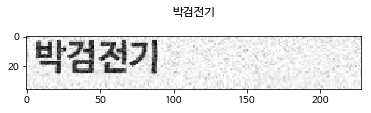

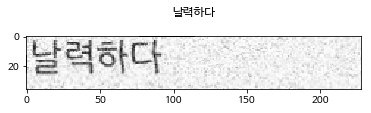

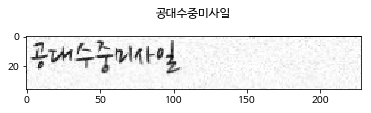

In [6]:
X,Y = train_gen[0]
for i in range(3):
    image = X['images'][i,:,:,0]
    plt.title(compose_unicode(Y['output_seqs'][i])[0])
    plt.imshow(image,cmap='gray')
    plt.show()

# \[ 모델 구성하기 \]

## 1. 모델 구성하기



In [7]:
from models.layers import Map2Sequence, ResidualConvFeatureExtractor
from models.layers import BLSTMEncoder, CTCDecoder, DotAttention
from models.layers import JamoEmbedding, JamoCompose, JamoClassifier

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import concatenate

In [8]:
K.clear_session()

height = 36

n_conv = 16 # the number of Convolution filter
n_state = 256 # the number of GRU units
n_embed = 16 # the size of embedding vector
n_clf = 256 # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(height, None, 1),name='images')
conv_maps = ResidualConvFeatureExtractor(n_conv,
                                         name='feature_extractor')(inputs)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)

# Embedding Layer
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
jamo_embedding_layer = JamoEmbedding(n_embed)
jamo_embedding = jamo_embedding_layer(decoder_inputs)

# Text Decoder
decoder_state_inputs = Input(shape=(n_state,), name='decoder_state')
gru_layer = GRU(n_state, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(jamo_embedding,
                           initial_state=decoder_state_inputs)

# Attention Layer
dotattend = DotAttention(n_state=n_state)
context, attention = dotattend([feature_seqs, states_decoder])

concat_state = concatenate([context, states_decoder],
                            axis=-1, name='concat_output')
# Classification Layer
jamo_clf = JamoClassifier(n_clf, name='output_seqs')
predictions = jamo_clf(concat_state)

## 2. 추론 모델과 학습 모델 구성하기

In [9]:
# For training
trainer = Model([inputs, 
                 decoder_inputs,
                 decoder_state_inputs], 
                 predictions, name='trainer')

# For Inference
# - (1) Encoder
encoder = Model(inputs, feature_seqs, 
                name='encoder')

# - (2) Decoder
num_feature = feature_seqs.shape.as_list()[-1]
states_encoder_input = Input((None, num_feature),
                             name='states_encoder_input')

context, attention = dotattend([states_encoder_input, states_decoder])
concat_state = concatenate([context, states_decoder], axis=-1, 
                            name='concat_output')
predictions = jamo_clf(concat_state)
output_decoder = JamoCompose(name='jamocompose')(predictions)

decoder = Model([states_encoder_input,
                 decoder_inputs,
                 decoder_state_inputs], 
                [states_decoder, output_decoder], name='decoder')

## 3. 학습 모델 Compile하기

In [11]:
y_true = tf.placeholder(shape=(None, None), dtype=tf.int32)

trainer.compile(AdamW(lr=1e-2),
                loss={
                    "output_seqs":jamo_categorical_crossentropy,
                },
                target_tensors=[y_true])

## 4. 모델 학습하기

Caution : 초기 3~5 Epoch까지는 Loss가 잘 떨어지지 않습니다. 몇 Epoch이 지난후 급격하게 떨어지기 시작합니다.


In [14]:
callbacks =[]
rlrop = ReduceLROnPlateau(
    factor=0.5, patience=2, 
    min_lr=1e-6, verbose=1,cooldown=5)
callbacks.append(rlrop)

epochs = 100

In [15]:
# 배치 사이즈는 64이상으로 해야 정상적으로 학습이 됩니다.
# 작은 배치는 훨씬 더 불안하게 학습해서 학습시간이 오히려 더 오래 걸립니다.
train_gen = JAMOSeq2SeqGenerator(train_set, batch_size=64,
                                 state_size=n_state)
valid_gen = JAMOSeq2SeqGenerator(valid_set, batch_size=64,
                                 state_size=n_state)

In [ ]:
# Multi-Processing Code에 이상이 있어서 잘 돌아가지 않습니다.
# 돌아가지 않으면 use_multiprocessing=False하고, 
hist = trainer.fit_generator(train_gen,
                             steps_per_epoch=1000,                               
                             epochs=epochs,
                             callbacks=callbacks)

## 5. 모델 평가하기

### (1) 평가할 데이터 가져오기

In [ ]:
X,_ = valid_gen[0]

# Target image 
target_images = X['images'][:10]

### (2) Encoder에서 이미지를 인코딩하기

In [ ]:
# Encoder 결과 계산
states_encoder_ = encoder.predict(target_images)

### (3) Decoder에서 텍스트를 디코딩하기

In [ ]:
EOS_TOKEN = ord('\n') # <EOS> 토큰

# Decoder
batch_size = target_images.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, n_state))

In [ ]:
# 재귀적으로 돌아감
result = np.zeros([batch_size,0])
while True:
    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = predictions_
    
    result = np.concatenate([result,prev_inputs],axis=-1)
    if np.all(np.any(result==EOS_TOKEN,axis=1)):
        break    
result = result[:,:].squeeze()
result = result.astype(np.int)

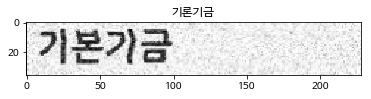

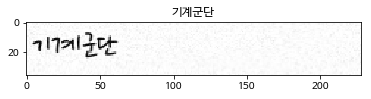

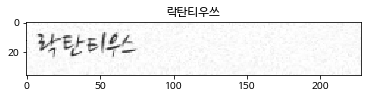

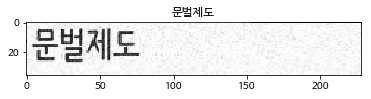

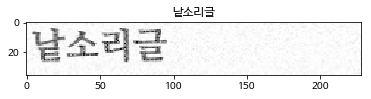

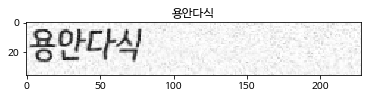

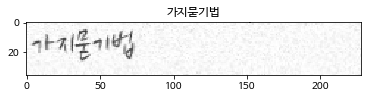

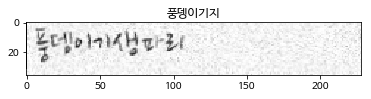

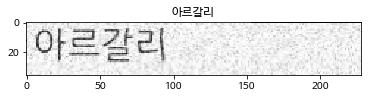

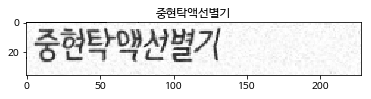

In [117]:
for image, seq in zip(target_images,result):
    text_seq = "".join([chr(char) for char in seq])
    text_seq = text_seq.split('\n')[0]
    
    plt.title(text_seq)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()